<a href="https://colab.research.google.com/github/Robyprass/robyprass/blob/main/23/09/2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/TomatoFT/Speech-Emotion-Recognition.git

Cloning into 'Speech-Emotion-Recognition'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 160 (delta 65), reused 60 (delta 14), pack-reused 20
Receiving objects: 100% (160/160), 57.01 MiB | 28.70 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [4]:
!pip install sounddevice
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install SpeechRecognition
!pip install portaudio
import sounddevice as sd
import soundfile as sf
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
libportaudiocpp0 is already the newest version (19.6.0-1).
portaudio19-dev is already the newest version (19.6.0-1).
libasound2-dev is already the newest version (1.1.3-5ubuntu0.6).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement portaudio (from versions: none)
ERROR: No match

In [5]:
datafil = 'Speech-Emotion-Recognition/01.wav'
import joblib
import librosa
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import sys
import warnings

In [6]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
data, sample_rate = librosa.load(datafil)

In [7]:
def Decoding(list):
    if list[0] == 0:
        return "Angry"
    elif list[0] == 1:
        return "Fear"
    elif list[0] == 2:
        return "Surprise"
    elif list[0] == 3:
        return "Disgust"
    elif list[0] == 4:
        return "Calm"
    elif list[0] == 5:
        return "Happy"
    elif list[0] == 6:
        return "Sad"
    else:
        return "Neutral"

In [8]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

In [9]:
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)


In [10]:
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

In [11]:
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [12]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [13]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    # res1 = extract_features(data)
    # result = np.array(res1)
    
    # # # data with noise
    # # noise_data = noise(data)
    # # res2 = extract_features(noise_data)
    # # result = np.vstack((result, res2)) # stacking vertically
    
    # # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.array(res3) # stacking vertically
    
    return result


In [ ]:
# Extract data and sampling rate from file
#data, fs = sf.read(filename, dtype='float32')  
#sd.play(data, fs)
#status = sd.wait()  



In [15]:
# Wait until file is done playing
CNN = tf.keras.models.load_model('Speech-Emotion-Recognition/Model/content/CNN')
LR = joblib.load("Speech-Emotion-Recognition/Model/LogisticRegresion.pkl")
SVM = joblib.load("Speech-Emotion-Recognition/Model/SVM.pkl")
Knn = joblib.load("Speech-Emotion-Recognition/Model/Knn.pkl")
test_case = 'Speech-Emotion-Recognition/01.wav'
featuring = get_features(test_case)
X3 = [featuring]
X4 = np.expand_dims(X3, axis=2)
nl = []

In [16]:
# scaler = StandardScaler()
# X3 = scaler.fit_transform(X3)
# X3 = X3.reshape(1, -1)
pred_test_1 = LR.predict(X3)
pred_test_2 = SVM.predict(X3)
pred_test_3 = Knn.predict(X3)
pred_test_4 = CNN.predict(X4)
# print(pred_test_3, type(pred_test_3))
pred_test_4 = pred_test_4.flatten()
i=0
for pred in pred_test_4:
    nl.append(pred)
index_max = max(nl)
# print(index_max)
# print(nl)
for pred in nl:
    if pred == index_max:
        print(i, type(i))
    else:
        i+=1
print(Decoding(np.ndarray(i)))

5 <class 'int'>
Neutral


In [17]:
# pred_test_4 = CNN.predict(X3)
# encoder2.fit_transform(np.array(Y1).reshape(-1, 1))
# y_pred2 = encoder2.inverse_transform(pred_test.reshape(-1, 1))
# print(f"Logistic Regression: {Decoding(pred_test_1)},SVM: {Decoding(pred_test_2)}, K-Nearest Neighbour: {Decoding(pred_test_3)}")
df = pd.DataFrame({"Logistic Regression":Decoding(pred_test_1),
                    "SVM": Decoding(pred_test_2),
                    "Knn": Decoding(pred_test_3),
                    'CNN': Decoding(np.ndarray(i))
                    }, index=["Prediction"])
print(df)

           Logistic Regression    SVM  Knn      CNN
Prediction                Fear  Angry  Sad  Neutral


Predict done

In [18]:
import os, sys
import matplotlib.pyplot as plt
import librosa.display

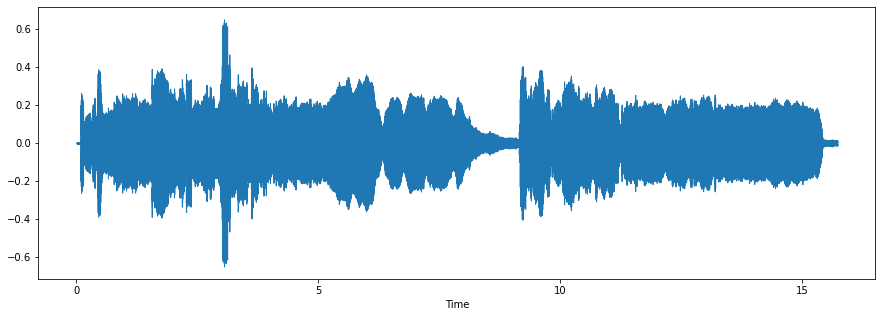

In [19]:
%matplotlib inline
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data)

In [20]:
import IPython.display as ipd  # To play sound in the notebook

In [21]:
ipd.Audio(datafil)

In [33]:
y, sr = librosa.load('Speech-Emotion-Recognition/01.wav')
librosa.feature.melspectrogram(y=y, sr=sr)

array([[2.6175275e-03, 1.1519779e-03, 7.6960394e-04, ..., 7.6013184e-03,
        7.4377046e-03, 7.0197531e-03],
       [1.6850677e-03, 3.3503273e-03, 4.5748595e-03, ..., 4.5016982e-02,
        4.1602027e-02, 3.0060073e-02],
       [5.9267331e-04, 1.1219177e-03, 1.2674198e-03, ..., 1.2003400e-02,
        9.1101909e-03, 6.2879780e-03],
       ...,
       [4.6239822e-07, 4.4482815e-07, 6.8666236e-07, ..., 5.0573285e-06,
        6.2987278e-06, 8.3251598e-06],
       [4.7640352e-08, 5.8404225e-08, 9.6261189e-08, ..., 5.0849866e-07,
        5.3796964e-07, 5.4797107e-07],
       [4.4457069e-09, 2.0169812e-09, 1.0424909e-09, ..., 7.4977411e-09,
        1.4412705e-08, 3.3497532e-08]], dtype=float32)

In [34]:
D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D, sr=sr)

In [35]:
# Passing through arguments to the Mel filters
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                    fmax=8000)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

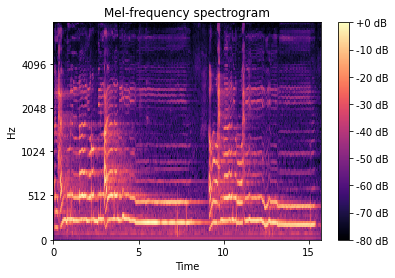

In [36]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [40]:
X, sample_rate = librosa.load(('Speech-Emotion-Recognition/01.wav'), res_type='kaiser_fast')
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)